In [1]:
using LinearAlgebra, ToeplitzMatrices
using JuMP, COSMO
using Plots
using BSON: @load

Data from video is stored in "vineQVF.bson", and contains:

Q, a matrix containing the pin joint angles at each timestep: 
    $[q^{(1)} ... q^{(K)}]$
    
V, a matrix containing the pin joint angular velocities at each timestep: 
    $[v^{(1)} ... v^{(K)}]$
    
F, a matrix containing the pin joint torques at each timestep:
    $[f^{(1)} ... f^{(K)}]$

In [2]:
# load dataset
@load "vineQVF.bson" Q V F
numPins, numTimesteps = size(Q)

(40, 165)

In [3]:
# set up for optimization Ax = y
A = [Q' V']
A = kron(A,Matrix(I,numPins,numPins))

y = vec(F);

In [7]:
# set weights matrix
v = .1*[0;0;[i for i = range(.3, 1, length = numPins-2)]]
WK = Toeplitz(v,v)

v = .1*[i for i = range(.1, 1, length = numPins)]
WC = Toeplitz(v,v)

W = Diagonal(vec([WK WC]))

# show WK
WK

40×40 Toeplitz{Float64,Complex{Float64}}:
 0.0        0.0        0.03       …  0.0962162  0.0981081  0.1
 0.0        0.0        0.0           0.0943243  0.0962162  0.0981081
 0.03       0.0        0.0           0.0924324  0.0943243  0.0962162
 0.0318919  0.03       0.0           0.0905405  0.0924324  0.0943243
 0.0337838  0.0318919  0.03          0.0886486  0.0905405  0.0924324
 0.0356757  0.0337838  0.0318919  …  0.0867568  0.0886486  0.0905405
 0.0375676  0.0356757  0.0337838     0.0848649  0.0867568  0.0886486
 0.0394595  0.0375676  0.0356757     0.082973   0.0848649  0.0867568
 0.0413514  0.0394595  0.0375676     0.0810811  0.082973   0.0848649
 0.0432432  0.0413514  0.0394595     0.0791892  0.0810811  0.082973
 0.0451351  0.0432432  0.0413514  …  0.0772973  0.0791892  0.0810811
 0.047027   0.0451351  0.0432432     0.0754054  0.0772973  0.0791892
 0.0489189  0.047027   0.0451351     0.0735135  0.0754054  0.0772973
 ⋮                                ⋱                        
 0.07918

In [6]:
# solve optimization
model = JuMP.Model(COSMO.Optimizer)

@variable(model, K[1:numPins, 1:numPins], PSD)
@variable(model, C[1:numPins, 1:numPins], PSD)

x = [vec(-K);vec(-C)]
@objective(model, Min,(A*x-y)'*(A*x-y) + x'*W*x)

JuMP.optimize!(model)

------------------------------------------------------------------
          COSMO v0.7.1 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2020
------------------------------------------------------------------

Problem:  x ∈ R^{1640},
          constraints: A ∈ R^{1640x1640} (1640 nnz),
          matrix size to factor: 3280x3280 (245318 nnz)
Sets:     DensePsdConeTriangle of dim: 820
          DensePsdConeTriangle of dim: 820
Settings: ϵ_abs = 1.0e-04, ϵ_rel = 1.0e-04,
          ϵ_prim_inf = 1.0e-06, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1.0e-6, α = 1.6,
          max_iter = 2500,
          scaling iter = 10 (on),
          check termination every 40 iter,
          check infeasibility every 40 iter,
          KKT system solver: CHOLMOD
Setup Time: 3542.47ms

Iter:	Objective:	Primal Res:	Dual Res:	Rho:
40	-7.6415e-01	1.3086e-03	5.8982e-03	1.0000e-01
80	-7.6484e-01	3.2484e-04	3.6392e-03	1.0000e-01
120	-7.6

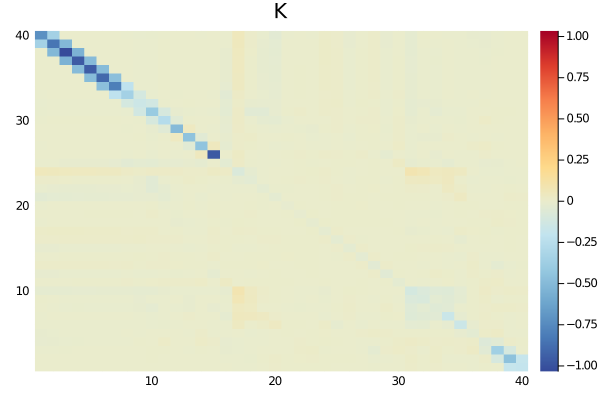

In [8]:
# show K
K = -JuMP.value.(K)
lim = maximum(abs.(K))
theme(:vibrant)
heatmap(reverse(K, dims=1), title="K", clim=(-lim,lim))

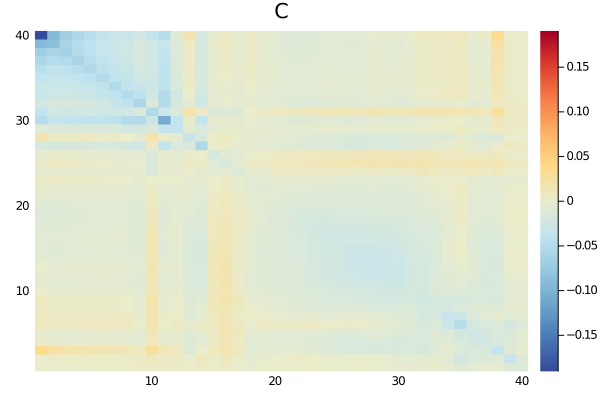

In [9]:
# show C
C = -JuMP.value.(C)
lim = maximum(abs.(C))
theme(:vibrant)
heatmap(reverse(C, dims=1), title="C", clim=(-lim,lim))

In [10]:
# compute goodness of fit
x = [vec(K);vec(C)] 
SSR = (A*x-y)'*(A*x-y)
SST = norm(y .- sum(y)/length(y))^2
Rsq = 1.0 - SSR/SST

0.64830567887977